In [1]:
import pandas as pd 
import numpy as np 
from scipy.optimize import minimize,basinhopping,brentq
import matplotlib.pyplot as plt
from scipy.stats import norm
import statsmodels.api as sm

Import data, use 2018 stock price as sample;

Calculate log return and variance of log return;

Set var0= variance of sample log return, set u0=0;

Import SP500 transaction volume for 2018

In [2]:
stock=pd.read_csv('SPX 2018 Stock Prices.csv').Close
stock_1=stock.shift(1)
log_return=np.log(stock_1/stock).dropna()
print(log_return.head())
var0=log_return.var()
mu=log_return.mean()
print(var0)
print(mu)
u0=0
volume=pd.read_csv('GSPC.csv',header=0,index_col=0,)['Volume'].loc['2018-01-02':'2018-12-31']
log_volume=np.log(volume)
print(log_volume.head())

1   -0.006378
2   -0.004021
3   -0.007009
4   -0.001661
5   -0.001302
Name: Close, dtype: float64
0.00011635038632924255
0.00032581662553679254
Date
2018-01-02    21.937362
2018-01-03    21.987014
2018-01-04    22.030317
2018-01-05    21.897795
2018-01-08    21.899657
Name: Volume, dtype: float64


Define Garch model function and Maximum likelihood estimation function


In [3]:
def garch(loadings,u0,var0):
    var1=loadings[0]+loadings[1]*var0+loadings[2]*u0**2
    return var1

def garch_all(x, u0, var0, stock):
    N=len(stock)
    vart=np.zeros(N)
    ut=np.zeros(N)
    for i in range(N):
        if i==0:
            vart[i]=var0
            ut[i]=u0
        else:
            vart[i]=x[0]+x[1]*vart[i-1]+x[2]*ut[i-1]**2
            ut[i]=np.log(stock[i]/stock[i-1])-mu
    return vart[1:],ut[1:] #MLE need the sum of var and mu from var1 and mu1 to the last var and mu

def MLE(garch_all, x, u0, var0, stock):
    N=len(stock)-1 
    zero_part=-N/2*np.log(2*np.pi)
    vart=garch_all(x,u0,var0,stock)[0]
    first_part=-0.5*(np.log(vart).sum())
    ut=garch_all(x,u0,var0,stock)[1]
    second_part=-0.5*(((ut/np.sqrt(vart))**2).sum())
    LogL=zero_part+first_part+second_part
    return LogL

#below is after adding log_volume as facotr
def garch1(loadings,u0,var0,log_volume0):
    var1=loadings[0]+loadings[1]*var0+loadings[2]*u0**2+loadings[3]*log_volume0
    return var1

def garch_all1(x, u0, var0, stock, log_volume):
    N=len(stock)
    vart=np.zeros(N)
    ut=np.zeros(N)
    for i in range(N):
        if i==0:
            vart[i]=var0
            ut[i]=u0
        else:
            vart[i]=x[0]+x[1]*vart[i-1]+x[2]*ut[i-1]**2+x[3]*log_volume[i-1]
            ut[i]=np.log(stock[i]/stock[i-1])-mu
    return vart[1:],ut[1:] #MLE need the sum of var and mu from var1 and mu1 to the last var and mu

def MLE1(garch_all1, x, u0, var0, stock, log_volume):
    N=len(stock)-1 
    zero_part=-N/2*np.log(2*np.pi)
    vart=garch_all1(x,u0,var0,stock,log_volume)[0]
    first_part=-0.5*(np.log(vart).sum())
    ut=garch_all1(x,u0,var0,stock,log_volume)[1]
    second_part=-0.5*(((ut/np.sqrt(vart))**2).sum())
    LogL=zero_part+first_part+second_part
    return LogL

Use optimization to get the loadings of Garch model

In [5]:
fun=lambda x: -MLE(garch_all, x, u0, var0, stock)
fun1=lambda x: -MLE1(garch_all1, x, u0, var0, stock, log_volume)
beta0=0.00001 
beta1=0.5
beta2=0.2
beta3=0.0000001

initialguess=(beta0, beta1, beta2) 
initialguess1=(beta0, beta1, beta2, beta3) 

methods=['Nelder-Mead','Powell','CG','BFGS','L-BFGS-B','TNC','COBYLA',
         'SLSQP','trust-constr','dogleg','trust-ncg','trust-exact','trust-krylov']

#local minimization
#res=minimize(fun, initialguess,method='Nelder-Mead',tol=1e-10)
#res1=minimize(fun1, initialguess1,method='Nelder-Mead',tol=1e-10)

#global minimization, 30 times iteration will take about 10 minutes
#the result is almost the same as local minimization for garch without macro factor
#the result is different from local minimization for garch with macro factor
res=basinhopping(fun, initialguess,stepsize=0.1, minimizer_kwargs={'method':'Nelder-Mead'},niter=30)
res1=basinhopping(fun1, initialguess1,stepsize=0.1, minimizer_kwargs={'method':'Nelder-Mead'},niter=30)

loadings=res.x
loadings1=res1.x

result=res.fun
result1=res1.fun

print(loadings)
print(loadings1)

print(result)
print(result1)

/Users/zhaoyudong/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in log
/Users/zhaoyudong/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in sqrt
/Users/zhaoyudong/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:50: RuntimeWarning: invalid value encountered in log
/Users/zhaoyudong/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:52: RuntimeWarning: invalid value encountered in sqrt


[5.83340118e-06 7.58874196e-01 2.19422884e-01]
[4.09899245e-06 7.59169516e-01 2.18965297e-01 7.86056940e-08]
-809.1515010647579
-809.1712548176961


Assume the SP500 transaction volume follows AR1 model, use regression to the get the loadings of this model

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.318
Model:                            OLS   Adj. R-squared:                  0.315
Method:                 Least Squares   F-statistic:                     115.6
Date:                Fri, 17 Apr 2020   Prob (F-statistic):           2.19e-22
Time:                        11:10:17   Log-Likelihood:                 124.20
No. Observations:                 250   AIC:                            -244.4
Df Residuals:                     248   BIC:                            -237.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          9.5920      1.153      8.318      0.0

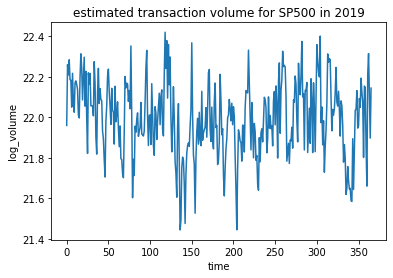

In [6]:
Y=np.array(log_volume[1:])
X0=np.array(log_volume[:-1])
X=sm.add_constant(X0)

res3=sm.OLS(Y,X).fit()
print(res3.summary())
theta,lamda=res3.params
print(theta,lamda)
resid=res3.resid
sigma_ut=resid.std()
print(sigma_ut)

N=365
log_volume_est=np.zeros(N+1)
for i in range(N+1):
    if i==0:
        log_volume_est[i]=log_volume[-1]
    else:
        ut=np.random.normal(0,sigma_ut)
        log_volume_est[i]=theta+lamda*log_volume_est[i-1]+ut
plt.plot(range(N+1),log_volume_est)
plt.xlabel('time')
plt.ylabel('log_volume')
plt.title('estimated transaction volume for SP500 in 2019')
plt.savefig('estimated transaction volume for SP500 in 2019',dpi=300)
plt.show()

 

Generate One path of variance and one path of error for constant variance, garch variance and garch+macroeconomic factor variance

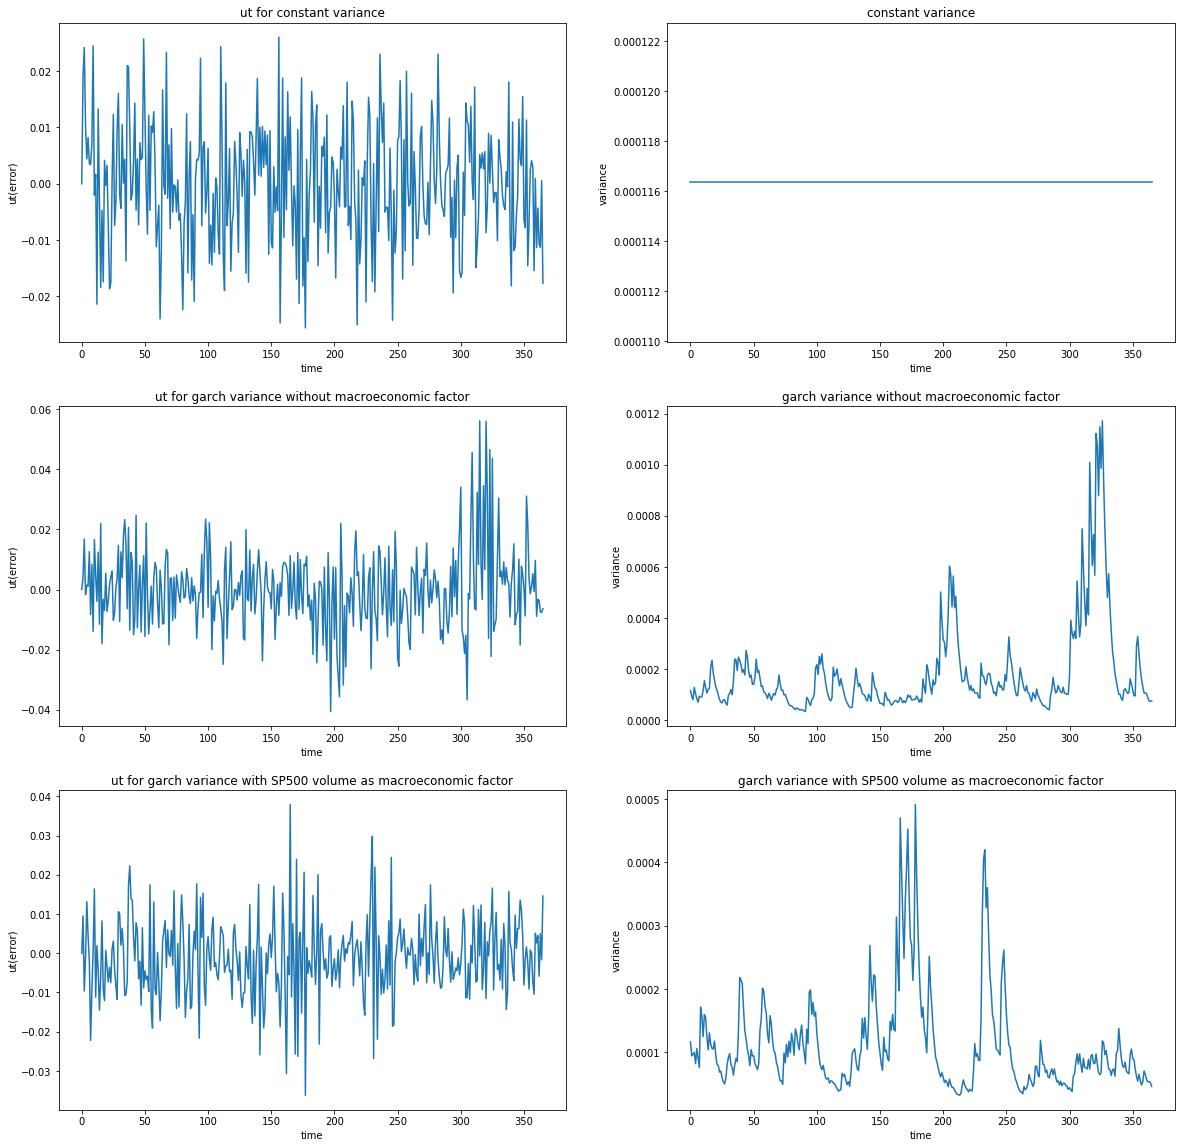

In [7]:
#constant variance
vart0=np.array([var0]*(N+1))#This will change to constant vol
ut0=np.zeros(N+1)

#garch variance without macroeconomic factor
vart=np.zeros(N+1)
ut=np.zeros(N+1)

#garch vairance with SP500 volume as macroeconomic factor
vart1=np.zeros(N+1)
ut1=np.zeros(N+1)
np.random.seed(0)


for i in range(N+1):
    if i==0:
        ut0[i]=u0
        
        vart[i]=var0
        ut[i]=u0
        
        vart1[i]=var0
        ut1[i]=u0
    else:
        ut0[i]=np.random.normal(0,np.sqrt(vart0[i]))
        
        vart[i]=garch(loadings,ut[i-1],vart[i-1])
        ut[i]=np.random.normal(0,np.sqrt(vart[i]))
        
        vart1[i]=garch1(loadings1,ut1[i-1],vart1[i-1],log_volume_est[i-1])
        ut1[i]=np.random.normal(0,np.sqrt(vart1[i]))

fig=plt.figure(figsize=(20,20))
row=3
column=2
ax1=fig.add_subplot(row,column,1)
ax1.plot(range(N+1),ut0)
ax1.set_xlabel('time')
ax1.set_ylabel('ut(error)')
ax1.set_title('ut for constant variance')

ax2=fig.add_subplot(row,column,2)
ax2.plot(range(N+1),vart0)
ax2.set_xlabel('time')
ax2.set_ylabel('variance')
ax2.set_title('constant variance')

ax3=fig.add_subplot(row,column,3)
ax3.plot(range(N+1),ut)
ax3.set_xlabel('time')
ax3.set_ylabel('ut(error)')
ax3.set_title('ut for garch variance without macroeconomic factor')

ax4=fig.add_subplot(row,column,4)
ax4.plot(range(N+1),vart)
ax4.set_xlabel('time')
ax4.set_ylabel('variance')
ax4.set_title('garch variance without macroeconomic factor')

ax5=fig.add_subplot(row,column,5)
ax5.plot(range(N+1),ut1)
ax5.set_xlabel('time')
ax5.set_ylabel('ut(error)')
ax5.set_title('ut for garch variance with SP500 volume as macroeconomic factor')

ax6=fig.add_subplot(row,column,6)
ax6.plot(range(N+1),vart1)
ax6.set_xlabel('time')
ax6.set_ylabel('variance')
ax6.set_title('garch variance with SP500 volume as macroeconomic factor')
plt.savefig('ut and variance comparison')
plt.show()


Genetate and EMS adjusted Monte Carlo for constant variance, garch variance and garch+macroeconomic factor variance

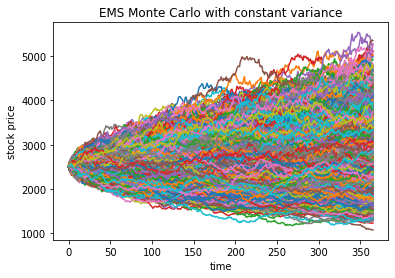

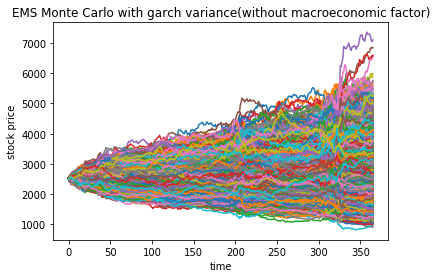

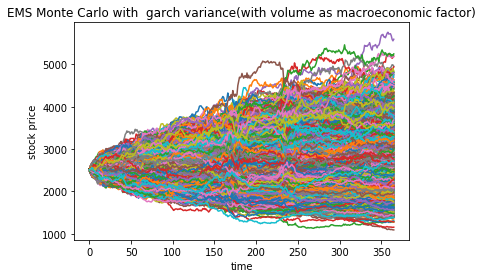

In [8]:
S0=2510 #use the stock price of the first trading day of 2019
r=0.01/100 #use the daily risk free rate on the first trading day of 2019
n=10000

#constant variance
S_hat0=np.zeros((n,N+1))
S_hat0[:,0]=S0
St0=np.zeros((n,N+1))
St0[:,0]=S0

#garch variance without macroeconomic factor
S_hat=np.zeros((n,N+1))
S_hat[:,0]=S0
St=np.zeros((n,N+1))
St[:,0]=S0

#garch variance with macroeconomic factor
S_hat1=np.zeros((n,N+1))
S_hat1[:,0]=S0
St1=np.zeros((n,N+1))
St1[:,0]=S0

for i in range(1,N+1):
    #constant variance
    epsilon=np.random.randn(n)
    S_hat0[:,i]=S_hat0[:,i-1]*np.exp(r-vart0[i]/2+np.sqrt(vart0[i])*epsilon)
    Z0=S_hat0[:,i]/S_hat0[:,i-1]*St0[:,i-1]
    Z0_0=1/n*(np.exp(-i*r)*Z0.sum())
    St0[:,i]=S0*Z0/Z0_0
    
    #garch variance without macroeconomic factor
    S_hat[:,i]=S_hat[:,i-1]*np.exp(r-vart[i]/2+np.sqrt(vart[i])*epsilon)
    Z=S_hat[:,i]/S_hat[:,i-1]*St[:,i-1]
    Z0=1/n*(np.exp(-i*r)*Z.sum())
    St[:,i]=S0*Z/Z0
    
    #garch variance with macroeconomic factor
    S_hat1[:,i]=S_hat1[:,i-1]*np.exp(r-vart1[i]/2+np.sqrt(vart1[i])*epsilon)
    Z1=S_hat1[:,i]/S_hat1[:,i-1]*St1[:,i-1]
    Z1_0=1/n*(np.exp(-i*r)*Z1.sum())
    St1[:,i]=S0*Z1/Z1_0

for i in range(n):
    plt.plot(range(0,N+1),St0[i,:])    
plt.xlabel('time')
plt.ylabel('stock price')
plt.title('EMS Monte Carlo with constant variance')
plt.savefig('EMS Monte Carlo with constant variance',dpi=300)
plt.show()

for i in range(n):
    plt.plot(range(0,N+1),St[i,:])   
plt.xlabel('time')
plt.ylabel('stock price')
plt.title('EMS Monte Carlo with garch variance(without macroeconomic factor)')
plt.savefig('EMS Monte Carlo with garch variance(without macroeconomic factor)',dpi=300)
plt.show()

for i in range(n):
    plt.plot(range(0,N+1),St1[i,:])   
plt.xlabel('time')
plt.ylabel('stock price')
plt.title('EMS Monte Carlo with  garch variance(with volume as macroeconomic factor)')
plt.savefig('EMS Monte Carlo with  garch variance(with volume as macroeconomic factor)',dpi=300)
plt.show()


Import Data, Use the options data of 2019, the excel file has already been processed, only contain the first day of 2019 (20190102), otherwise the file is too large to read;

Drop the data with volume smaller than 30, we consider it illiquid, so the option price is not accurate;

For simplicity, we only use SPX options, so drop SPXW options;

For simplicity, we drop the data with maturity smaller than 30 or bigger than 365;

Form a new DataFrame to store the options T,K,F,price and Type;

Group Data by maturity.

In [9]:
options=pd.read_excel('2019 SPX Options 1day.xlsx',parse_dates=['The Date of this Price','Expiration Date of the Option'])
options.drop(options.index[options.Volume<30],inplace=True)
options.drop(options.index[options['Option Symbol'].str.contains('SPXW')],inplace=True)

Type=options['C=Call, P=Put']
T=(options['Expiration Date of the Option']-options['The Date of this Price']).dt.days
K=options['Strike Price of the Option Times 1000']/1000
F=options['Forward Price']
price=(options['Highest Closing Bid Across All Exchanges']+options['Lowest  Closing Ask Across All Exchanges'])/2
vol=options['Implied Volatility of the Option']

options_new=pd.concat((T,K,F,price,vol,Type),axis=1,keys=['T','K','F','Price','Vol','Type'])
options_new.drop(options_new.index[(options_new['T']>365)| (options_new['T']<30)],inplace=True)
options_new=options_new.dropna()
print(options_new.head())
options_groups=options_new.groupby('T')
Ts=options_new['T'].unique()
print(Ts)

      T       K            F   Price       Vol Type
810  44  2350.0  2513.948566  184.25  0.229784    C
815  44  2375.0  2513.948566  163.95  0.225710    C
816  44  2380.0  2513.948566  159.95  0.224745    C
828  44  2440.0  2513.948566  114.95  0.213550    C
830  44  2450.0  2513.948566  107.90  0.211259    C
[ 44  72 106 170 261 352]


In [10]:
def BlackScholes(S, K, r, sigma, T, Type):
    d1 = (np.log(S/K)+(r+sigma**2/2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    if Type=='C':
        return S*norm.cdf(d1) - K*np.exp(-r*T)*norm.cdf(d2)
    elif Type=='P':
        return K*np.exp(-r*T)*norm.cdf(-d2) - S*norm.cdf(-d1)

def impliedVolatility(S,K,r,price,T,Type):
    impliedVol= brentq(lambda x: price -BlackScholes(S, K, r, x, T,Type), 1e-8, 1)
    return impliedVol

For each maturity, we divid the options into call and put options, drop in the moeny call and put options, then we store the options prices and implied vol corresponding to different K;

Calculate the estimated option price for constant variance, garch variance and garch+macroeconomic factor variance model

Calculate the implied vol for estimated options price constant variance, garch variance and garch+macroeconomic factor variance

Combine the actual price, estimated price, acutal implied vol and estimated implied vol into a DataFrame;

Update the this given maturity in a dictionary, key=maturity, value=one DataFrame

In [11]:
options_all={}
for i in Ts:
    Price_cons=[]
    Price_garch=[]
    Price_garchf=[]
    
    Vol_cons=[]
    Vol_garch=[]
    Vol_garchf=[]
    
    options_group=options_groups.get_group(i)
    options_divide=options_group.groupby('Type')
    options_put=options_divide.get_group('P').copy()
    options_put.sort_values('K',inplace=True)
    options_call=options_divide.get_group('C').copy()
    options_call.sort_values('K',inplace=True)

    options_put.drop(options_put.index[options_put.K>options_put.F],inplace=True)
    for j in options_put.K:
        estimate_cons=1/n*np.exp(-r*i)*(np.maximum(j-St0[:,i],0).sum())
        estimate_garch=1/n*np.exp(-r*i)*(np.maximum(j-St[:,i],0).sum())
        estimate_garchf=1/n*np.exp(-r*i)*(np.maximum(j-St1[:,i],0).sum())
        #for a 1 year Maturity option, T=365, while stock only change 252 times,such T need to mutiply by scale_factor
        Price_cons.append(estimate_cons)
        Price_garch.append(estimate_garch)
        Price_garchf.append(estimate_garchf)
        
        vol_cons= impliedVolatility(S0,j,r*365,estimate_cons,i/365,'P')
        vol_garch= impliedVolatility(S0,j,r*365,estimate_garch,i/365,'P')
        vol_garchf= impliedVolatility(S0,j,r*365,estimate_garchf,i/365,'P')
        Vol_cons.append(vol_cons)
        Vol_garch.append(vol_garch)
        Vol_garchf.append(vol_garchf) 
        
    options_call.drop(options_call.index[options_call.K<options_call.F],inplace=True)
    for k in options_call.K:
        estimate_cons=1/n*np.exp(-r*i)*(np.maximum(St0[:,i]-k,0).sum())
        estimate_garch=1/n*np.exp(-r*i)*(np.maximum(St[:,i]-k,0).sum())
        estimate_garchf=1/n*np.exp(-r*i)*(np.maximum(St1[:,i]-k,0).sum())
        #for a 1 year Maturity option, T=365, while stock only change 252 times,such T need to mutiply by scale_factor
        Price_cons.append(estimate_cons)
        Price_garch.append(estimate_garch)
        Price_garchf.append(estimate_garchf)
        
        vol_cons= impliedVolatility(S0,k,r*365,estimate_cons,i/365,'C')
        vol_garch= impliedVolatility(S0,k,r*365,estimate_garch,i/365,'C')
        vol_garchf= impliedVolatility(S0,k,r*365,estimate_garchf,i/365,'C')
        
        Vol_cons.append(vol_cons)
        Vol_garch.append(vol_garch)
        Vol_garchf.append(vol_garchf)    

    options_group=pd.concat((options_put,options_call))
    options_group.set_index('K',inplace=True)
    opt=pd.DataFrame(Price_cons,columns=['P_cons var'],index=options_group.index)
    opt['P_garch var']=Price_garch
    opt['P_garchf var']=Price_garchf
    opt['P_actual']=options_group.Price
    
    opt['Vol_cons var']=Vol_cons
    opt['Vol_garch var']=Vol_garch
    opt['Vol_garchf var']=Vol_garchf
    opt['Vol_actual']=options_group.Vol
    options_all.update({i:opt})

print(options_all)

{44:         P_cons var  P_garch var  P_garchf var  P_actual  Vol_cons var  \
K                                                                       
1000.0    0.000000     0.000000      0.000000     0.175  1.000000e-08   
1650.0    0.000000     0.000000      0.000000     0.675  1.000000e-08   
1700.0    0.000000     0.000000      0.000000     0.875  1.000000e-08   
1800.0    0.000000     0.000000      0.000000     1.275  1.000000e-08   
1875.0    0.000000     0.000000      0.000000     1.775  1.000000e-08   
...            ...          ...           ...       ...           ...   
2770.0    7.824821    10.563037      6.969838     2.375  2.030793e-01   
2780.0    7.004978     9.602191      6.225802     2.025  2.030069e-01   
2800.0    5.609842     7.925073      4.949047     1.450  2.030666e-01   
2825.0    4.218119     6.199402      3.691987     1.025  2.031885e-01   
2900.0    1.714142     2.810343      1.409274     0.425  2.038760e-01   

        Vol_garch var  Vol_garchf var  Vol_ac

Plot the atual price, estimated price and price error for each maturity

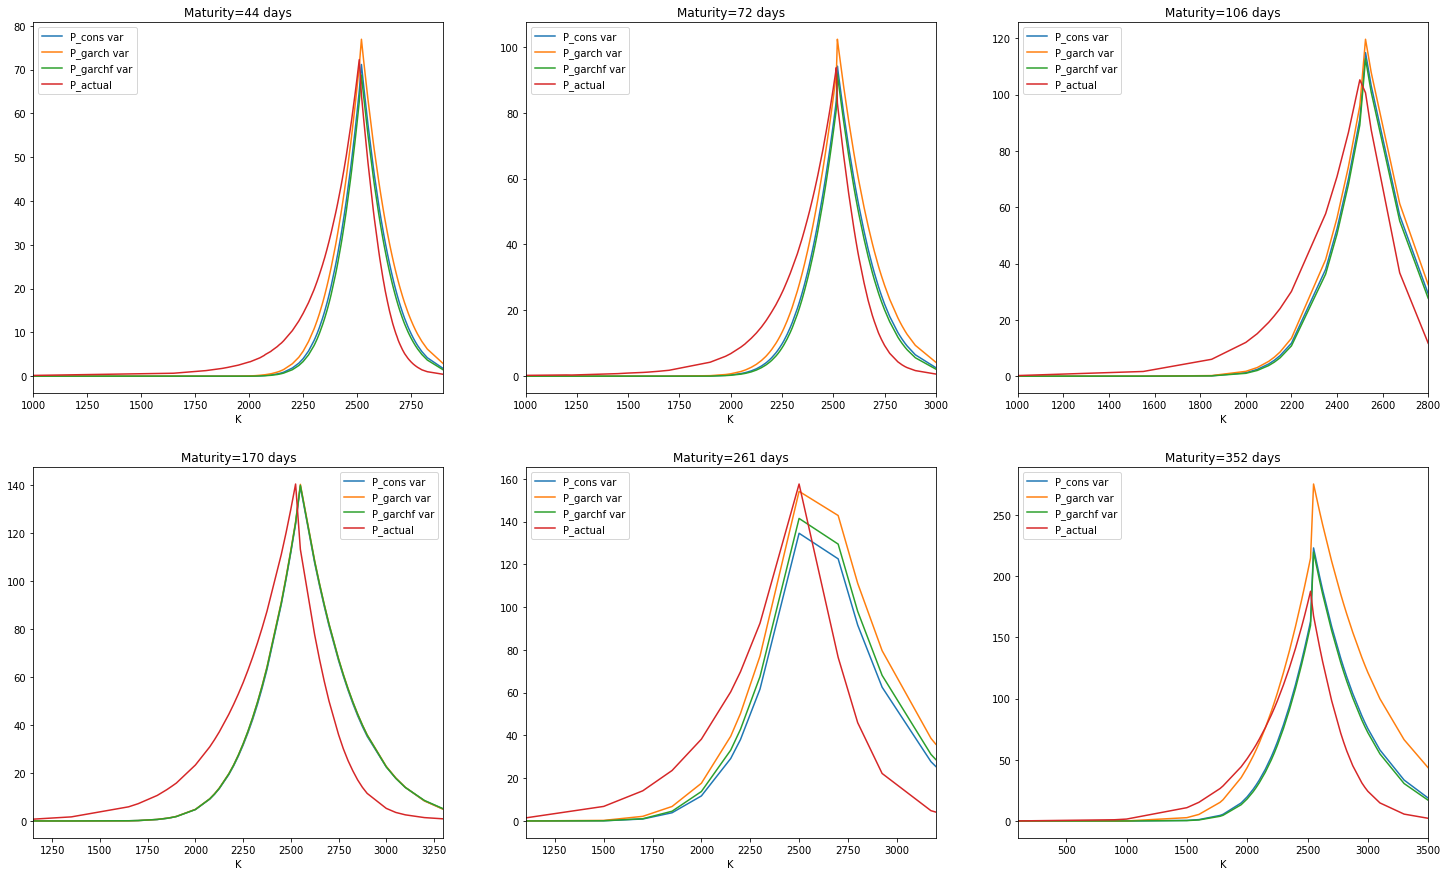

In [12]:
fig=plt.figure()
row=2
column=len(Ts)/row
for i in range(1,len(Ts)+1):
    ax=fig.add_subplot(row,column,i)
    options_group=options_all[Ts[i-1]]
    options_group[['P_cons var','P_garch var','P_garchf var','P_actual']].plot(ax=ax,title='Maturity=%s days'% Ts[i-1],figsize=(25,15))
plt.savefig('option price comparison')
plt.show()

Plot the acutal implied vol and estimated implied vol for each maturity

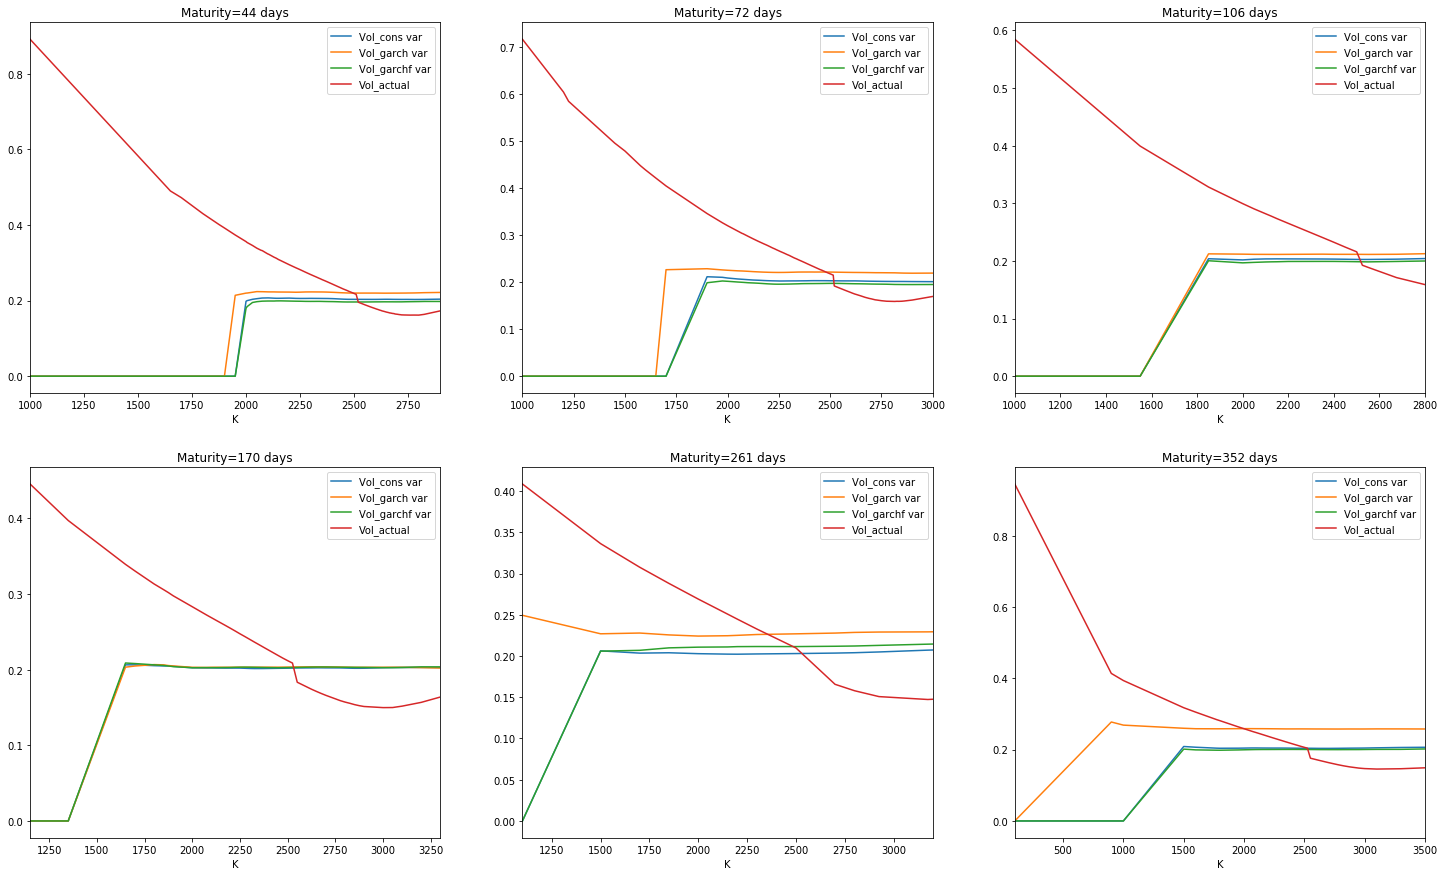

In [13]:
fig=plt.figure()
row=2
column=len(Ts)/row
for i in range(1,len(Ts)+1):
    ax=fig.add_subplot(row,column,i)
    options_group=options_all[Ts[i-1]]
    options_group[['Vol_cons var','Vol_garch var','Vol_garchf var','Vol_actual']].plot(ax=ax,title='Maturity=%s days'% Ts[i-1],figsize=(25,15))
plt.savefig('option implied vol comparison')
plt.show()